In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.io.wavfile import read
from scipy.signal import get_window
from scipy.fftpack import fft, ifft, dct, idct

In [2]:
def read_sound(file):
  """ read a mono wav sound file and convert it to a floating point array

    Args:
      file (str): File name
    Returns:
      x (numpy.array): Array of samples as float
      fs (int): Sample rate
  """
  fs, x = read(file)
  y = np.float32(x) / 2**15
  return y, fs

def display_sound(x, fs=44100):
  """ Display a signal x

    Args:
      x (numpy.array): Array of samples
      fs (int): Sample rate
  """
  plt.figure(0, figsize=(10, 4))
  t = np.arange(0, x.size/fs, 1.0/fs)
  plt.plot(t,x)
  plt.xlabel('time (seconds)')
  plt.ylabel('amplitude')
  ipd.display(ipd.Audio(data=x, rate=fs))
  plt.show()

def sine_window(M):
  n = np.arange(M)
  w0 = np.sin((n+0.5)*np.pi/(M))
  w = w0 / ( np.sum(w0))
  return w

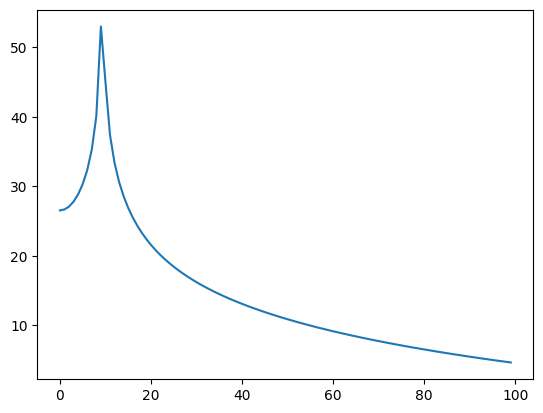

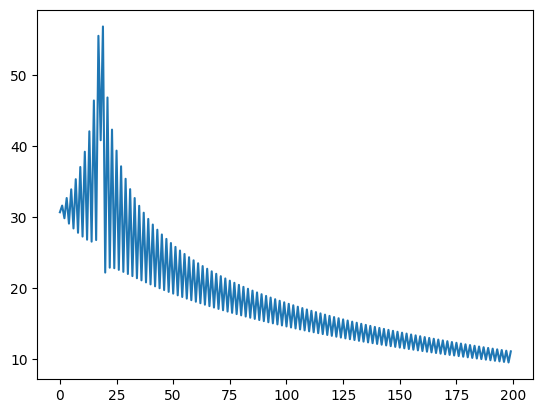

In [3]:
fs = 44100
f = 400.0
nsamples = 1024
x = np.sin(2*np.pi*f*np.arange(0,nsamples/fs,1.0/fs))

# compute the DFT
X = fft(x)
plt.plot(20*np.log10(np.abs(X[:100])))
plt.show()

# compute the dct
X1 = dct(x, type=4)
plt.plot(20*np.log10(np.abs(X1[0:200])))
plt.show()

In [4]:
N = 1024

#The D(z) matrix:
def Dmatrix(samples):
    #implementation of the delay matrix D(z)
    N = len(samples)
    out=np.zeros(N)
    out[0:int(N/2)]=Dmatrix.z
    Dmatrix.z=samples[0:int(N/2)]
    out[int(N/2):N]=samples[int(N/2):N]
    return out

Dmatrix.z=np.zeros(int(N/2))

#The inverse D(z) matrix:
def Dmatrixinv(samples):
    #implementation of the delay matrix D(z)
    N = len(samples)
    out=np.zeros(N)
    out[int(N/2):N]=Dmatrixinv.z
    Dmatrixinv.z=samples[int(N/2):N]
    out[0:int(N/2)]=samples[0:int(N/2)]
    return out

Dmatrixinv.z=np.zeros(int(N/2))

#The F Matrix:
fcoeff=np.sin(np.pi/(2*N)*(np.arange(0,2*N)+0.5))
Fmatrix=np.zeros((N,N))
Fmatrix[0:int(N/2),0:int(N/2)]=np.fliplr(np.diag(fcoeff[0:int(N/2)]))
Fmatrix[int(N/2):N,0:int(N/2)]=np.diag(fcoeff[int(N/2):N])
Fmatrix[0:int(N/2),int(N/2):N]=np.diag(fcoeff[N:int(N+N/2)])
Fmatrix[int(N/2):N,int(N/2):N]=-np.fliplr(np.diag(fcoeff[int(N+N/2):(2*N)]))

#The inverse F matrix:
Finv=np.linalg.inv(Fmatrix)

#The complete MDCT, Analysis:
def MDCT(samples):
    y=np.dot(samples,Fmatrix)
    y=Dmatrix(y)
    y=dct(y,type=4)
    return y

#The inverse MDCT, synthesis:
def MDCTinv(y):
    #inverse DCT4 is identical to DCT4:
    x=idct(y,type=4)
    #inverse D(z) matrix
    x=Dmatrixinv(x)
    #inverse F matrix
    x=np.dot(x,Finv)
    return x

/var/folders/l3/g0bl2h853g72yx1shwfkd7w00000gp/T/ipykernel_28229/3712549219.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  y1 = np.float64(ifft(Xf[i,:]))


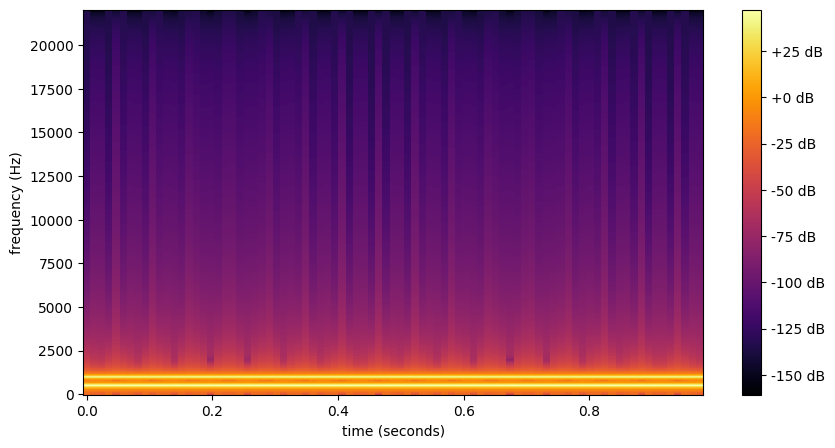

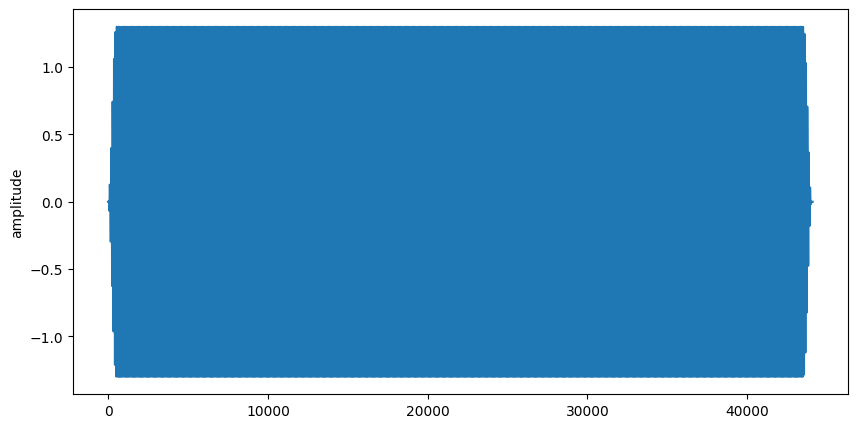

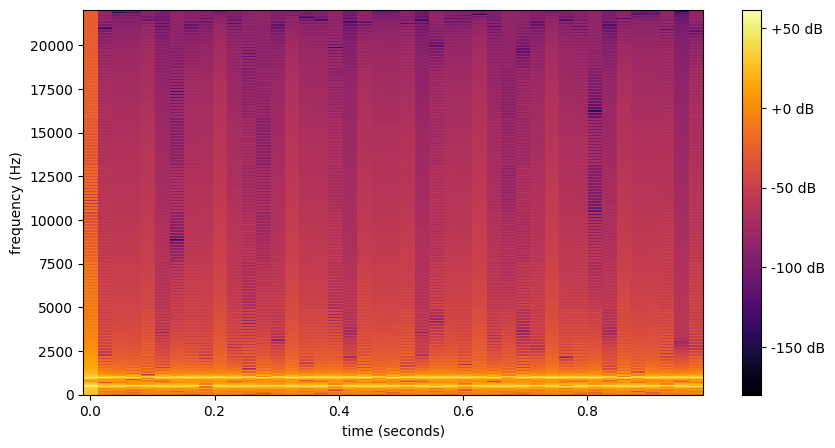

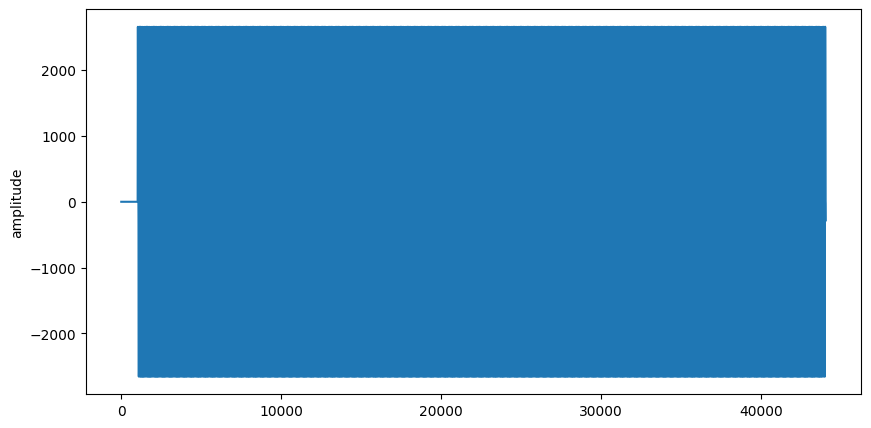

In [5]:
# Generate a test sound signal (e.g., a combination of two sine waves)
fs = 44100  # Sampling frequency
duration = 1.0  # Duration of the signal in seconds
t = np.linspace(0, duration, fs, endpoint=False)  # Time vector

# Generate a signal (a combination of two sine waves)
f1, f2 = 500, 1000  # Frequencies of the sine waves
x = np.sin(2 * np.pi * f1 * t) + 0.5 * np.sin(2 * np.pi * f2 * t)

ipd.display(ipd.Audio(data=x, rate=fs))

N = 1024
H = 512

# compute STFT
i = 0
w = get_window('han', N)
Xf = []
while i < x.size-N:
  X = fft(w*x[i:i+N])
  Xf.append(X)
  i += H

Xf = np.array(Xf)

# display spectrogram
plt.figure(figsize=(10, 5))
t = np.arange(0, i/fs, H/fs)
f = np.arange(0, fs/2, fs/N)
plt.pcolormesh(t, f, np.transpose(20*np.log10(abs(Xf[:,:N//2]))), shading='nearest', cmap='inferno')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('time (seconds)')
plt.ylabel('frequency (Hz)')

# compute inverse-STFT
n = 0
i = 0
y = np.zeros(x.size)
while i < Xf[:,0].size:
  y1 = np.float64(ifft(Xf[i,:]))
  y[n:n+N] += y1
  i += 1
  n += H

# display output sound
ipd.display(ipd.Audio(data=y, rate=fs))
plt.figure(figsize=(10, 5))
plt.plot(y)
plt.ylabel('amplitude')
plt.show()

# compute MCDT
i = 0
Xf = []
while i < x.size-N:
  X = MDCT(x[i:i+N])
  Xf.append(np.array(X))
  i += N

#display spectrogram using the MCDT
Xf = np.array(Xf)
plt.figure(figsize=(10, 5))
t = np.arange(0, i/fs, N/fs)
f = np.arange(0, fs/2, fs/(2*N))
plt.pcolormesh(t, f, np.transpose(20*np.log10(np.abs(Xf))), shading='nearest', cmap='inferno')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('time (seconds)')
plt.ylabel('frequency (Hz)')
plt.show()

# compute the inverse of the MCDT
i = 0
y = []
while i < Xf[:,0].size:
  y1 = MDCTinv(Xf[i,:])
  y = np.append(y, y1)
  i += 1

# display output sound
ipd.display(ipd.Audio(data=y, rate=fs))
plt.figure(figsize=(10, 5))
plt.plot(y)
plt.ylabel('amplitude')
plt.show()

(512,)


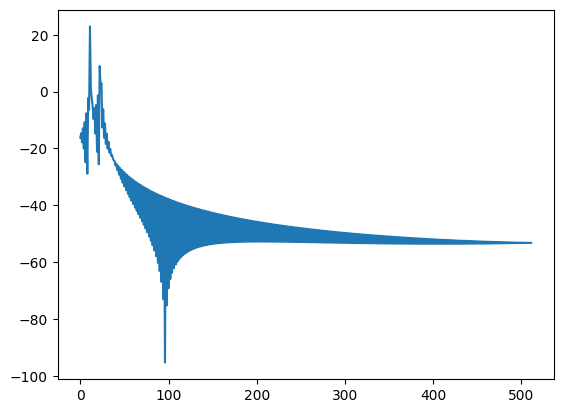

(1024,)


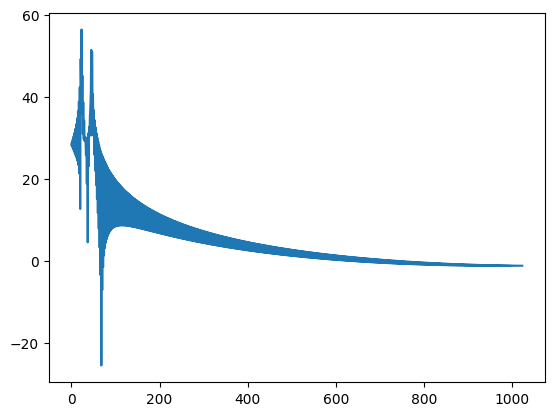

In [6]:
def mdct4(x):
    N = x.shape[0]
    if N%4 != 0:
        raise ValueError("MDCT4 only defined for vectors of length multiple of four.")
    M = N // 2
    N4 = N // 4

    rot = np.roll(x, N4)
    rot[:N4] = -rot[:N4]
    t = np.arange(0, N4)
    w = np.exp(-1j*2*np.pi*(t + 1./8.) / N)
    c = np.take(rot,2*t) - np.take(rot, N-2*t-1)         - 1j * (np.take(rot, M+2*t) - np.take(rot,M-2*t-1))
    c = (2./np.sqrt(N)) * w * np.fft.fft(0.5 * c * w, N4)
    y = np.zeros(M)
    y[2*t] = np.real(c[t])
    y[M-2*t-1] = -np.imag(c[t])
    return y

mdct_spectrogram = mdct4(x[0:1024])
print(mdct_spectrogram.shape)
plt.plot(20 * np.log10(np.abs(mdct_spectrogram) + 1e-6))
plt.show()


mdct_spectrogram = MDCT(x[0:1024])
print(mdct_spectrogram.shape)
plt.plot(20 * np.log10(np.abs(mdct_spectrogram) + 1e-6))
plt.show()